## Импорты библиотек

In [ ]:
!pip install -q torchdiffeq

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [24]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

## Фиксируем единый сид

In [25]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


SEED = 42  
seed_everything(SEED)

## Загрузка данных электропотребления

In [102]:
def print_df_info(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    print(df.describe())
    return df.sample(10)


df = pd.read_excel('EnergyConsumption.xls')
print_df_info(df)

(8760, 5)
           WeekDay  ConsumprionMWtH  TemperatureC
count  8760.000000      8760.000000   8760.000000
mean      4.005479      1234.852426      3.038357
std       2.000107       363.852685     14.639117
min       1.000000       516.364014    -30.780681
25%       2.000000       945.324326     -7.599720
50%       4.000000      1216.037262      3.605505
75%       6.000000      1509.718674     15.410224
max       7.000000      2169.305786     34.087811


,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
4850,2005-07-22 02:00:00,5,1900-07-20 02:00:00,591.755188,15.829189
8015,2005-11-30 23:00:00,3,1900-11-28 23:00:00,1197.351379,-12.742069
3070,2005-05-08 22:00:00,7,1900-05-06 22:00:00,756.566895,8.266714
1811,2005-03-17 11:00:00,4,1900-03-15 11:00:00,1507.638611,-1.212544
1221,2005-02-20 21:00:00,7,1900-02-19 21:00:00,1387.793701,-19.887650
6935,2005-10-16 23:00:00,7,1900-10-14 23:00:00,953.309265,4.718071
6038,2005-09-09 14:00:00,5,1900-09-07 14:00:00,1037.599792,14.314333
7745,2005-11-19 17:00:00,6,1900-11-17 17:00:00,1634.770569,-8.423408
3844,2005-06-10 04:00:00,5,1900-06-08 04:00:00,895.509766,14.420130
1033,2005-02-13 01:00:00,7,1900-02-12 01:00:00,1308.754517,-23.357668


**Преобразование данных**

In [103]:
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = df['Date'].dt.hour
df['Month'] = df['Date'].dt.month

## Визуализация временного ряда

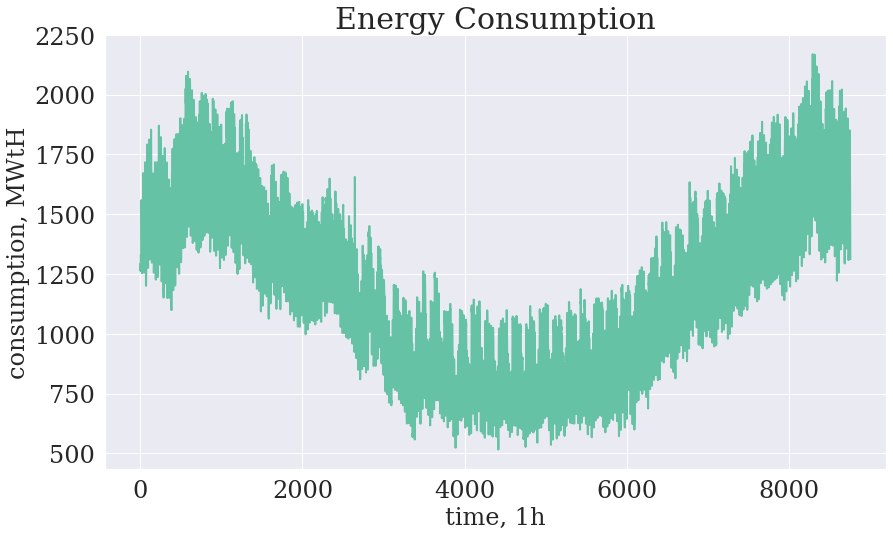

In [104]:
df.iloc[:, 3].plot()
plt.title('Energy Consumption')
plt.xlabel('time, 1h')
plt.ylabel('consumption, MWtH')
plt.show()

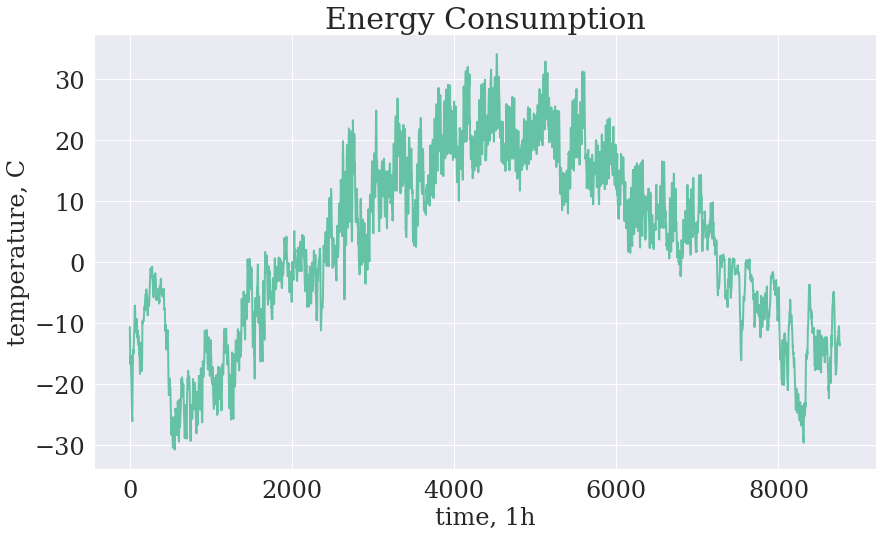

In [105]:
df.iloc[:, 4].plot()
plt.title('Energy Consumption')
plt.xlabel('time, 1h')
plt.ylabel('temperature, C')
plt.show()

## Предобработка данных

**Построение эмбеддингов**

In [106]:
#time_shifts = [1, 2, 3, 24, 48, 72, 24*7, 24*7*2, 24*7*3][::-1]
time_shifts = [1, 2, 3, 4, 5, 6, 7, 8, 9][::-1]

df_emb = df.iloc[:, 3:4]
df_emb.columns = ['energy']

for shift in time_shifts:
    df_emb[f'energy-{shift}h'] = df_emb.iloc[:, 0].shift(shift)

df_emb.dropna(inplace=True)
X_energy = df_emb.iloc[:, 1:].values
y_energy = df_emb.iloc[:, 0].values
df_emb

,energy,energy-9h,energy-8h,energy-7h,energy-6h,energy-5h,energy-4h,energy-3h,energy-2h,energy-1h
9,1318.807861,1289.617859,1265.573853,1273.188232,1279.703979,1292.839539,1263.411804,1279.445496,1304.194458,1330.222046
10,1300.406494,1265.573853,1273.188232,1279.703979,1292.839539,1263.411804,1279.445496,1304.194458,1330.222046,1318.807861
11,1303.879883,1273.188232,1279.703979,1292.839539,1263.411804,1279.445496,1304.194458,1330.222046,1318.807861,1300.406494
12,1328.283325,1279.703979,1292.839539,1263.411804,1279.445496,1304.194458,1330.222046,1318.807861,1300.406494,1303.879883
13,1441.479736,1292.839539,1263.411804,1279.445496,1304.194458,1330.222046,1318.807861,1300.406494,1303.879883,1328.283325
...,...,...,...,...,...,...,...,...,...,...
8755,1645.486206,1648.377258,1621.634033,1661.647766,1755.252075,1841.413086,1850.705078,1821.647461,1772.975342,1714.301025
8756,1540.930969,1621.634033,1661.647766,1755.252075,1841.413086,1850.705078,1821.647461,1772.975342,1714.301025,1645.486206
8757,1394.492859,1661.647766,1755.252075,1841.413086,1850.705078,1821.647461,1772.975342,1714.301025,1645.486206,1540.930969
8758,1348.616089,1755.252075,1841.413086,1850.705078,1821.647461,1772.975342,1714.301025,1645.486206,1540.930969,1394.492859


**Разбиение на обучающую и тестовую выборки**

In [110]:
from sklearn.model_selection import train_test_split


train_ratio = 0.74

X_train, X_test, y_train, y_test = train_test_split(
    X_energy,
    y_energy,
    train_size=train_ratio,
    shuffle=False
)

print('Train size =', X_train.shape[0])
print('Test size =', X_test.shape[0])

Train size = 6475
Test size = 2276


**Нормализация**

In [111]:
from sklearn.preprocessing import StandardScaler


energy_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_norm = energy_scaler.fit_transform(X_train)
X_test_norm = energy_scaler.transform(X_test)

y_train_norm = target_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_test_norm = target_scaler.transform(y_test.reshape(-1, 1)).squeeze()

**Построение Dataset-a**

In [112]:
class EnergyDataset(Dataset):
    def __init__(self, energy_data: np.ndarray, target: np.ndarray):
        assert len(energy_data) == len(target)
        self.energy = torch.from_numpy(energy_data).float()
        self.target = torch.from_numpy(target).float()
    
    def __len__(self):
        return len(self.energy)
    
    def __getitem__(self, index: int):
        if index >= len(self):
            raise IndexError(f'{self.__class__.__name__} index out of range')
            
        return self.energy[index], self.target[index]
    

train_dataset = EnergyDataset(X_train_norm, y_train_norm)
test_dataset = EnergyDataset(X_test_norm, y_test_norm)

**Построение DataLoader-a**

In [113]:
batch_size = 200
tr_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
tst_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

## Модели предсказания

### 1. LSTM

In [114]:
from typing import Optional


class LSTMModel(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hid_dim: int,
                 num_layers: int,
                 device: torch.device):
        super().__init__()
        
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hid_dim
        self.device = device
        
        self.lstm = nn.LSTM(input_dim, hid_dim, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hid_dim, 1).to(device)
        
    def forward(self,
                x: torch.tensor,
                hn: Optional[torch.tensor] = None,
                cn: Optional[torch.tensor] = None) -> torch.tensor:
        # x.shape = (batch_size, seq_len, input_dim)
        # hm.shape = (num_layers, batch_size, hid_dim)
        # out.shape = (batch_size, seq_len, hid_dim)
        batch_size = x.shape[0]
        
        if hn is None and cn is None:
            hn, cn = self.init(batch_size)
        elif hn is None:
            hn, _ = self.init(batch_size)
        elif cn is None:
            _, cn = self.init(batch_size)
        
        out, (hn, cn) = self.lstm(x, (hn, cn))
        final_out = self.fc(out[:, -1, :])
        
        return final_out, hn, cn

    def init(self, batch_size: int) -> (torch.tensor, torch.tensor):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        
        return h0, c0


input_dim = 1
hidden_dim = 28
num_layers = 1
device = torch.device('cpu')

model = LSTMModel(input_dim, hidden_dim, num_layers, device)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

print('Число параметров:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Число параметров: 3501


**Функции обучения**

In [115]:
def train_rnn(model, dataloader, optimizer, loss_fn, train_history=None):
    hn, cn = model.init(batch_size)
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, (energy_and_temp, target) in enumerate(dataloader):
        optimizer.zero_grad()
        
        energy_and_temp = torch.unsqueeze(energy_and_temp, 2).to(device)
        target = target.to(device)
        
        out, hn, cn = model.forward(energy_and_temp, hn, cn)
        loss = loss_fn(out.squeeze(), target)
        hn = hn.detach()
        cn = cn.detach()

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        
        if (i + 1) % 5 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

            clear_output(True)
            ax[0].plot(history)
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history)
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('General train history')
                
            plt.show()
            
    return hn, cn, epoch_loss / len(dataloader)

In [116]:
def test_rnn(model, dataloader, loss_fn, hn, cn):
    model.eval()
    
    epoch_loss = 0
    
    for energy_and_temp, target in dataloader:
        energy_and_temp = torch.unsqueeze(energy_and_temp, 2).to(device)
        target = target.to(device)
        
        out, hn, cn = model.forward(energy_and_temp, hn, cn)
        
        with torch.no_grad():
            loss = loss_fn(out.squeeze(), target)
        
        hn = hn.detach()
        cn = cn.detach()

        epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

**Обучение**

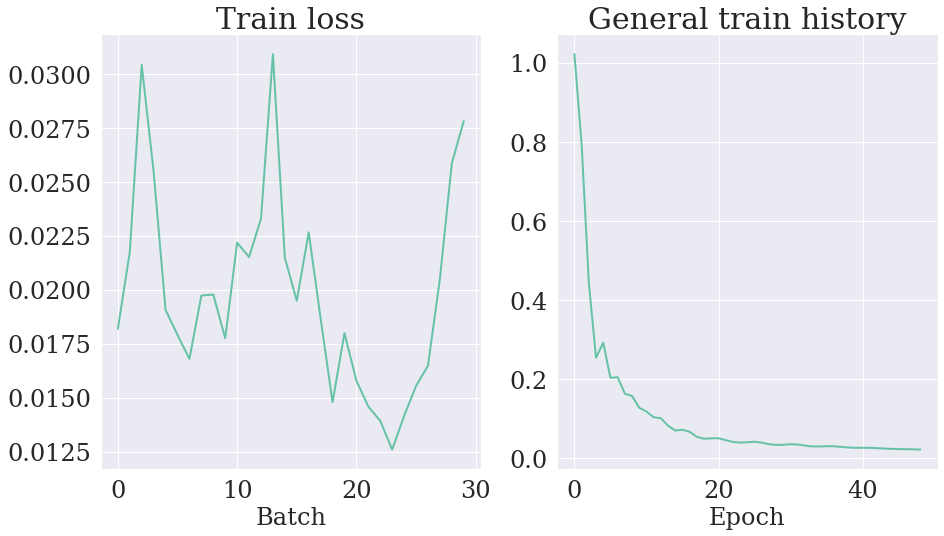

Train Loss: 0.021
Test Loss: 0.033
CPU times: user 5min 25s, sys: 10.8 s, total: 5min 35s
Wall time: 1min 47s


In [117]:
%%time
from tqdm.notebook import tqdm


epochs = 50
train_history = []
test_history = []

for epoch in tqdm(range(epochs)):
    print(f'epoch {epoch}')
    
    hn, cn, train_loss = train_rnn(model, tr_dataloader, optimizer, loss_fn, train_history)
    test_loss = test_rnn(model, tst_dataloader, loss_fn, hn, cn)
    
    train_history.append(train_loss)
    test_history.append(test_loss)
    
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')

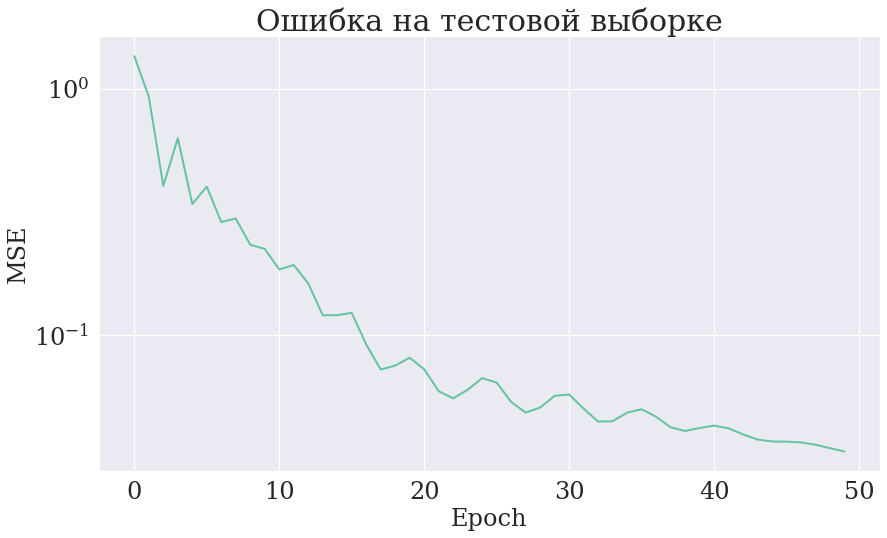

In [118]:
plt.title('Ошибка на тестовой выборке')
plt.plot(test_history)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

**Сохранение модели**

In [119]:
torch.save(model.state_dict(), 'lstm_model.pt')

**Финальное предсказание модели**

In [120]:
model.eval()
hn, cn = model.init(batch_size)
predictions = []

for energy_and_temp, _ in tst_dataloader:
    energy_and_temp = torch.unsqueeze(energy_and_temp, 2).to(device)
    
    with torch.no_grad():
        out, hn, cn = model.forward(energy_and_temp, hn, cn)
    predictions.append(out.squeeze())

    hn = hn.detach()
    cn = cn.detach()
    
lstm_predictions = torch.hstack(predictions).numpy()
lstm_predictions = target_scaler.inverse_transform(lstm_predictions[:, None]).squeeze()

**Графики**

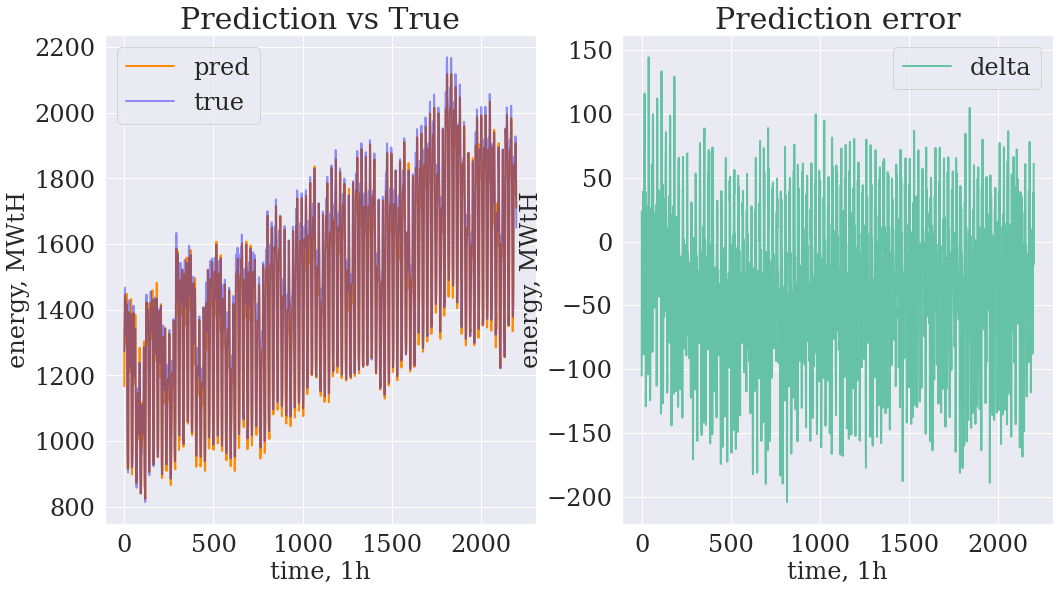

In [121]:
energy_consumption_true = y_test[:lstm_predictions.size]
lstm_deltas = lstm_predictions - energy_consumption_true

fig, axes = plt.subplots(1, 2, figsize=(17, 9))
axes[0].plot(lstm_predictions, label='pred', c='darkorange')
axes[0].plot(energy_consumption_true, label='true', c='blue', alpha=0.4)
axes[1].plot(lstm_deltas, label='delta')

axes[0].set_xlabel('time, 1h')
axes[0].set_ylabel('energy, MWtH')
axes[0].set_title('Prediction vs True')
axes[0].legend()

axes[1].set_xlabel('time, 1h')
axes[1].set_ylabel('energy, MWtH')
axes[1].set_title('Prediction error')
axes[1].legend()

plt.show()

**Ошибки**

In [122]:
from sklearn.metrics import r2_score


lstm_rmse = np.sqrt(np.mean(np.square(lstm_deltas)))
lstm_mae = np.mean(np.abs(lstm_deltas))
lstm_r2 = r2_score(energy_consumption_true, lstm_predictions)

print('RMSE =', lstm_rmse)
print('MAE =', lstm_mae)
print('R2 =', lstm_r2)

RMSE = 62.61235338097426
MAE = 48.97119861949574
R2 = 0.9499380617401572


### 2. ODE-RNN

**Dataset с временными метками и Dataloader**

In [90]:
def build_time_emb(time_shifts: list, start: int, size: int, denom: int = 1000):
    ts = np.arange(start, start+size).reshape(-1, 1)
    ts = np.broadcast_to(ts, (ts.size, len(time_shifts)))
    
    time_shifts = np.array(time_shifts).reshape(1, -1)
    return (ts - time_shifts) / denom


class EnergyAndTimeDataset(Dataset):
    def __init__(self, energy_data: np.ndarray, target: np.ndarray, ts: np.ndarray):
        assert len(energy_data) == len(target) == len(ts)
        
        self.energy = torch.from_numpy(energy_data).float()
        self.target = torch.from_numpy(target).float()
        self.time = torch.from_numpy(ts).float()
        
    def __len__(self):
        return len(self.energy)
    
    def __getitem__(self, index: int):
        if index >= len(self):
            raise IndexError(f'{self.__class__.__name__} index out of range')
            
        return self.energy[index], self.target[index], self.time[index]


#time_shifts = [1, 2, 3, 24, 48, 72, 24*7, 24*7*2, 24*7*3][::-1]
time_shifts = [1, 2, 3, 4, 5, 6, 7, 8, 9][::-1]
train_ts = build_time_emb(time_shifts, df_emb.index[0], y_train_norm.size)
test_ts = build_time_emb(
    time_shifts,
    df_emb.index[0]+y_train_norm.size,
    y_test_norm.size
)

train_dataset = EnergyAndTimeDataset(X_train_norm, y_train_norm, train_ts)
test_dataset = EnergyAndTimeDataset(X_test_norm, y_test_norm, test_ts)

batch_size = 200
tr_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
tst_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

**Модель**

In [91]:
from torchdiffeq import odeint
from typing import Optional


class ODEFunc(nn.Module):
    def __init__(self, ode_func_net):
        """
        ode_func_net: neural net that used to transform hidden state in ode
        """
        super(ODEFunc, self).__init__()
        self.gradient_net = ode_func_net

    def forward(self, t_local, y, backwards = False):
        """
        Perform one step in solving ODE. Given current data point y and
        current time point t_local, returns gradient dy/dt at this time point
        t_local: current time point
        y: value at the current time point
        """
        grad = self.get_ode_gradient_nn(t_local, y)
        if backwards:
            grad = -grad
        return grad

    def get_ode_gradient_nn(self, t_local, y):
        return self.gradient_net(y)

    def sample_next_point_from_prior(self, t_local, y):
        """
        t_local: current time point
        y: value at the current time point
        """
        return self.get_ode_gradient_nn(t_local, y)


class ODEGRU(nn.Module):
    def __init__(self,
                 hid_size: int,
                 ode_func: nn.Module,
                 device: torch.device):
        super().__init__()
        
        self.input_size = 1
        self.hid_size = hid_size
        self.device = device
        
        self.gru_cell = nn.GRUCell(self.input_size, hid_size).to(device)
        self.ode_func = ode_func.to(device)
        self.fc = nn.Linear(hid_size, 1).to(device)
        
    def forward(self, x: torch.tensor, ts: torch.tensor, h0: Optional[torch.tensor] = None):
        # x.shape = (batch_size, seq_len, 1)
        # ts.shape = (batch_size, seq_len)
        # h0.shape = (batch_size, hid_dim)
        batch_size, seq_len, _ = x.shape
        
        if h0 is None:
            h0 = torch.zeros(batch_size, self.hid_size).to(self.device)
            
        for i in range(seq_len):
            x_i = x[:, i, :]
            ts_i = ts[:, i]
            
            # h_next.shape = (batch_size, batch_size, hid_dim)
            h_next = odeint(self.ode_func, h0, ts_i, rtol=1e-03, atol=1e-05)
            h0 = torch.diagonal(h_next).T.to(self.device)
            h0 = self.gru_cell(x_i, h0)
            
        return self.fc(h0), h0

In [92]:
hidden_dim = 25
latent_dim = 25
ode_func = ODEFunc(nn.Sequential(
    nn.Linear(hidden_dim, latent_dim),
    nn.Tanh(),
    nn.Linear(latent_dim, hidden_dim)
))

device = torch.device('cpu')
ode_gru = ODEGRU(hidden_dim, ode_func, device)
loss_fn = nn.MSELoss()
optimizer = Adam(ode_gru.parameters(), lr=1e-3)
print('Число параметров:', sum(p.numel() for p in ode_gru.parameters() if p.requires_grad))

Число параметров: 3426


**Функции обучения**

In [93]:
def train_ode(model, dataloader, loss_fn, optimizer, train_history=None):
    hn = None
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, (energy, target, ts) in enumerate(dataloader):
        optimizer.zero_grad()
        
        energy = torch.unsqueeze(energy, 2).to(device)
        target = target.to(device)
        ts = ts.to(device)
        
        out, hn = model.forward(energy, ts, hn)
        loss = loss_fn(out.squeeze(), target)
        hn = hn.detach()

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        
        if (i + 1) % 5 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

            clear_output(True)
            ax[0].plot(history)
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history)
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('General train history')
                
            plt.show()
            
    return hn, epoch_loss / len(dataloader)

In [94]:
def test_ode(model, dataloader, loss_fn, hn):
    model.eval()
    
    epoch_loss = 0
    
    for energy, target, ts in dataloader:
        energy = torch.unsqueeze(energy, 2).to(device)
        target = target.to(device)
        ts = ts.to(device)
                
        with torch.no_grad():
            out, hn = model.forward(energy, ts, hn)
            loss = loss_fn(out.squeeze(), target)
        
        hn = hn.detach()

        epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

**Обучение**

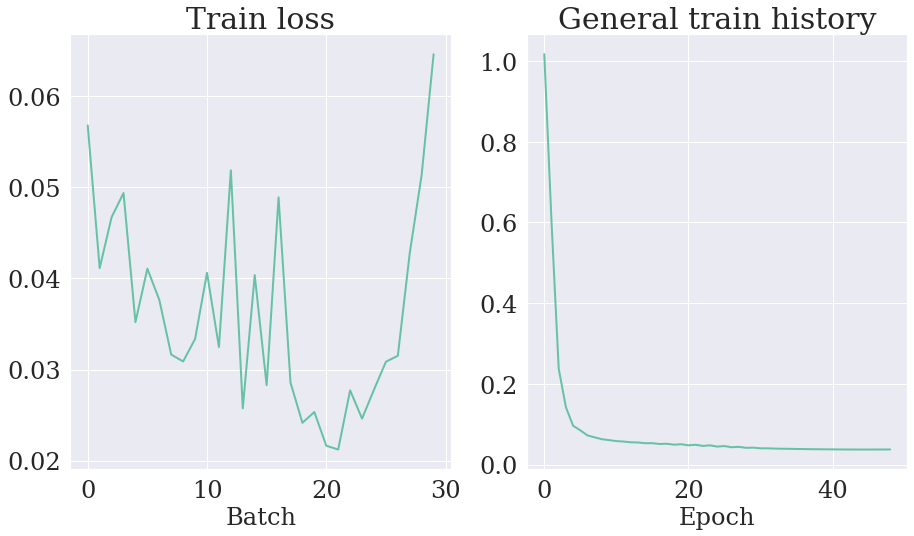

Train Loss: 0.037
Test Loss: 0.058


In [ ]:
%%time
from tqdm.notebook import tqdm


epochs = 50
train_history = []
test_history = []

for epoch in tqdm(range(epochs)):
    print(f'epoch {epoch}')
    
    hn, train_loss = train_ode(ode_gru, tr_dataloader, loss_fn, optimizer, train_history)
    test_loss = test_ode(ode_gru, tst_dataloader, loss_fn, hn)
    
    train_history.append(train_loss)
    test_history.append(test_loss)
    
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')

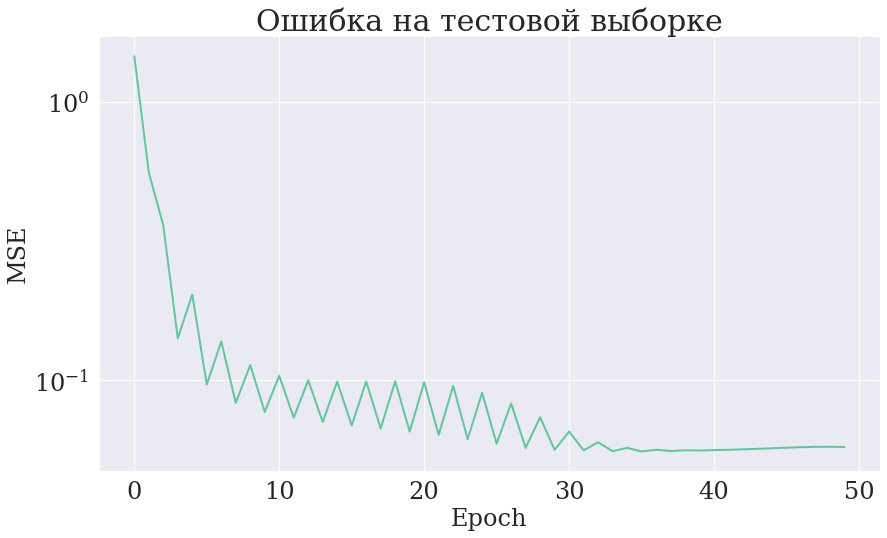

In [ ]:
plt.title('Ошибка на тестовой выборке')
plt.plot(test_history)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

**Сохранение модели**

In [ ]:
torch.save(ode_gru.state_dict(), 'ode_model.pt')

**Финальное предсказание модели**

In [ ]:
ode_gru.eval()
hn = None
predictions = []

for energy, _, ts in tst_dataloader:
    energy = torch.unsqueeze(energy, 2).to(device)
    ts = ts.to(device)
            
    with torch.no_grad():
        out, hn = ode_gru.forward(energy, ts, hn)

    predictions.append(out.squeeze())
    hn = hn.detach()
    
ode_predictions = torch.hstack(predictions).numpy()
ode_predictions = target_scaler.inverse_transform(ode_predictions[:, None]).squeeze()

**Графики**

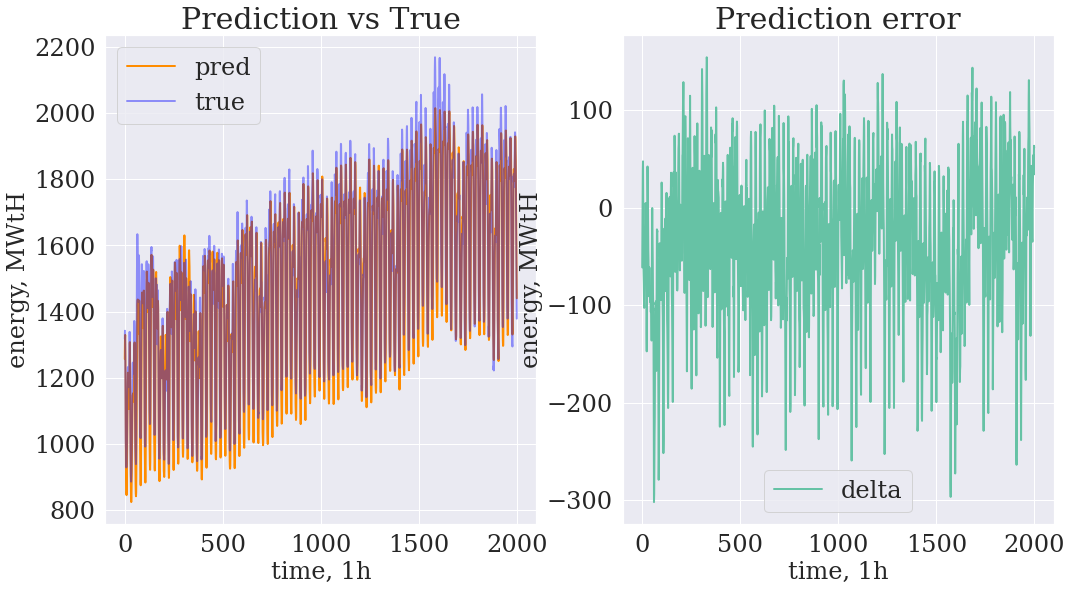

In [ ]:
energy_consumption_true = y_test[:ode_predictions.size]
ode_deltas = ode_predictions - energy_consumption_true

fig, axes = plt.subplots(1, 2, figsize=(17, 9))
axes[0].plot(ode_predictions, label='pred', c='darkorange')
axes[0].plot(energy_consumption_true, label='true', c='blue', alpha=0.4)
axes[1].plot(ode_deltas, label='delta')

axes[0].set_xlabel('time, 1h')
axes[0].set_ylabel('energy, MWtH')
axes[0].set_title('Prediction vs True')
axes[0].legend()

axes[1].set_xlabel('time, 1h')
axes[1].set_ylabel('energy, MWtH')
axes[1].set_title('Prediction error')
axes[1].legend()

plt.show()

**Ошибки**

In [ ]:
from sklearn.metrics import r2_score


ode_rmse = np.sqrt(np.mean(np.square(ode_deltas)))
ode_mae = np.mean(np.abs(ode_deltas))
ode_r2 = r2_score(energy_consumption_true, ode_predictions)

print('RMSE =', ode_rmse)
print('MAE =', ode_mae)
print('R2 =', ode_r2)

RMSE = 83.82107639774738
MAE = 65.49882849121094
R2 = 0.9033955496704056


## Разреженные данные

**Построение разреженного датасета**

In [96]:
def build_sparse_df(df: pd.DataFrame, alpha: float = 0.33) -> pd.DataFrame:
    assert 0 <= alpha <= 1
    
    n_observations = df.shape[0]
    k_dropped_elems = int(np.round(n_observations*alpha))
    
    ids_to_drop = np.random.randint(0, n_observations, k_dropped_elems)
    
    return df.drop(index=ids_to_drop)


ALPHA = 0.33
sparse_df = build_sparse_df(df, ALPHA).iloc[:, 3:4]
sparse_df.reset_index(inplace=True)
sparse_df.columns = ['hour', 'energy']

**Построение эмбедиингов**

In [97]:
time_shifts = [1, 2, 3, 4, 5, 6, 7, 8, 9][::-1]
ts_df = sparse_df.iloc[:, 0:1].copy() / 1000

for shift in time_shifts:
    sparse_df[f'energy-{shift}'] = sparse_df.energy.shift(shift)
    ts_df[f'hour-{shift}'] = ts_df.hour.shift(shift)

sparse_df.dropna(inplace=True)
ts_df.dropna(inplace=True)

X_energy = sparse_df.iloc[:, 2:].values
y_energy = sparse_df.iloc[:, 1].values
ts_emb = ts_df.iloc[:, 1:].values

train_ratio = 0.752

X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(
    X_energy,
    y_energy,
    ts_emb,
    train_size=train_ratio,
    shuffle=False
)

energy_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_norm = energy_scaler.fit_transform(X_train)
X_test_norm = energy_scaler.transform(X_test)

y_train_norm = target_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_test_norm = target_scaler.transform(y_test.reshape(-1, 1)).squeeze()

### LSTM

**Данные**

In [65]:
batch_size = 150

train_dataset = EnergyDataset(X_train_norm, y_train_norm)
test_dataset = EnergyDataset(X_test_norm, y_test_norm)

tr_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
tst_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

**Модель**

In [66]:
input_dim = 1
hidden_dim = 28
num_layers = 1
device = torch.device('cpu')

model = LSTMModel(input_dim, hidden_dim, num_layers, device)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

print('Число параметров:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Число параметров: 3501


**Обучение**

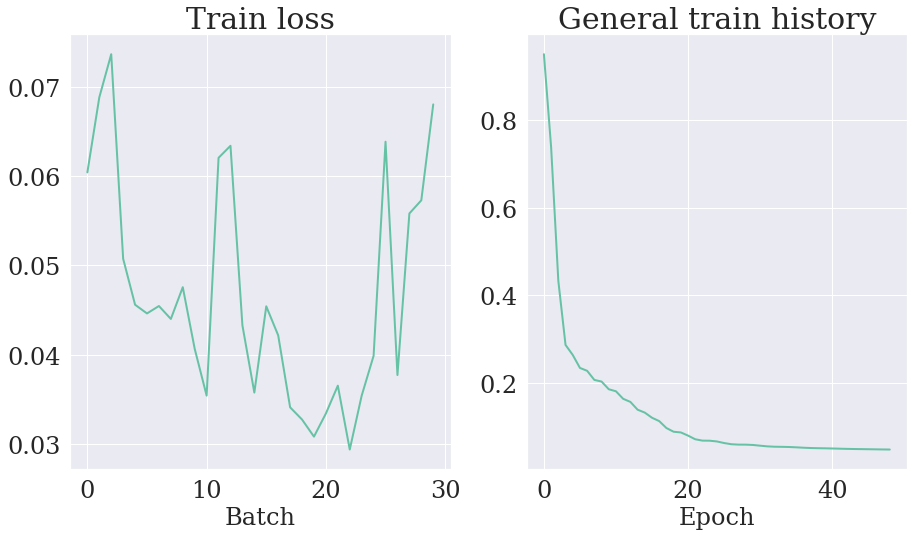

Train Loss: 0.048
Test Loss: 0.064


In [71]:
epochs = 50
train_history = []
test_history = []

for epoch in tqdm(range(epochs)):
    print(f'epoch {epoch}')
    
    hn, cn, train_loss = train_rnn(model, tr_dataloader, optimizer, loss_fn, train_history)
    test_loss = test_rnn(model, tst_dataloader, loss_fn, hn, cn)
    
    train_history.append(train_loss)
    test_history.append(test_loss)
    
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')
    
torch.save(model.state_dict(), f'lstm_model_{ALPHA}.pt')

**Оценка качества**

In [72]:
model.eval()
hn, cn = model.init(batch_size)
predictions = []

for energy_and_temp, _ in tst_dataloader:
    energy_and_temp = torch.unsqueeze(energy_and_temp, 2).to(device)
    
    with torch.no_grad():
        out, hn, cn = model.forward(energy_and_temp, hn, cn)
    predictions.append(out.squeeze())

    hn = hn.detach()
    cn = cn.detach()
    
lstm_predictions = torch.hstack(predictions).numpy()
lstm_predictions = target_scaler.inverse_transform(lstm_predictions[:, None]).squeeze()
energy_consumption_true = y_test[:lstm_predictions.size]
lstm_deltas = lstm_predictions - energy_consumption_true

lstm_rmse = np.sqrt(np.mean(np.square(lstm_deltas)))
lstm_mae = np.mean(np.abs(lstm_deltas))
lstm_r2 = r2_score(energy_consumption_true, lstm_predictions)

print('RMSE =', lstm_rmse)
print('MAE =', lstm_mae)
print('R2 =', lstm_r2)

RMSE = 288.18013376293953
MAE = 232.18848962402345
R2 = -0.09935328689256684


### ODE-GRU

**Данные**

In [98]:
batch_size = 150

train_dataset = EnergyAndTimeDataset(X_train_norm, y_train_norm, ts_train)
test_dataset = EnergyAndTimeDataset(X_test_norm, y_test_norm, ts_test)

tr_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
tst_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

**Модель**

In [99]:
hidden_dim = 25
latent_dim = 25
ode_func = ODEFunc(nn.Sequential(
    nn.Linear(hidden_dim, latent_dim),
    nn.Tanh(),
    nn.Linear(latent_dim, hidden_dim)
))

device = torch.device('cpu')
ode_gru = ODEGRU(hidden_dim, ode_func, device)
loss_fn = nn.MSELoss()
optimizer = Adam(ode_gru.parameters(), lr=1e-3)
print('Число параметров:', sum(p.numel() for p in ode_gru.parameters() if p.requires_grad))

Число параметров: 3426


**Обучение**

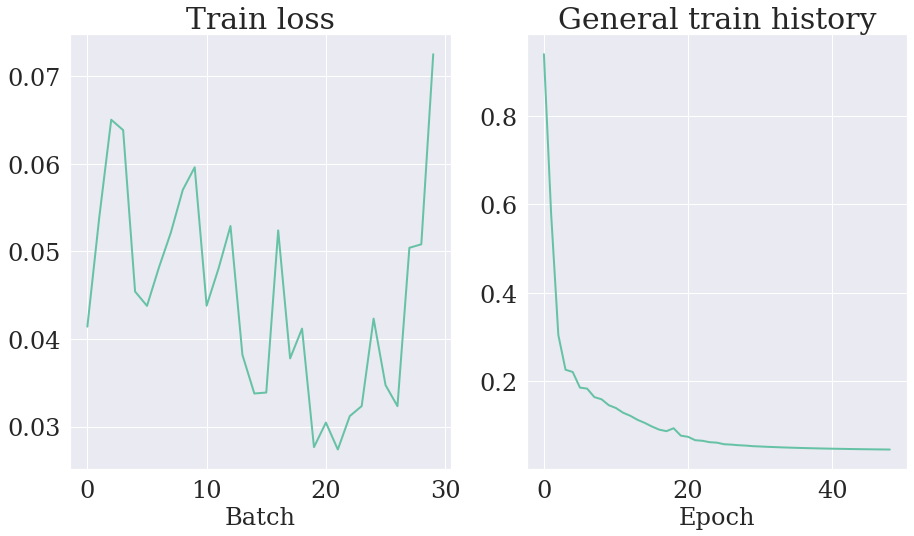

Train Loss: 0.046
Test Loss: 0.062


In [100]:
epochs = 50
train_history = []
test_history = []

for epoch in tqdm(range(epochs)):
    print(f'epoch {epoch}')
    
    hn, train_loss = train_ode(ode_gru, tr_dataloader, loss_fn, optimizer, train_history)
    test_loss = test_ode(ode_gru, tst_dataloader, loss_fn, hn)
    
    train_history.append(train_loss)
    test_history.append(test_loss)
    
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')
    
torch.save(ode_gru.state_dict(), f'ode_model_{ALPHA}.pt')

**Оценка качества**

In [101]:
ode_gru.eval()
hn = None
predictions = []

for energy, _, ts in tst_dataloader:
    energy = torch.unsqueeze(energy, 2).to(device)
    ts = ts.to(device)
            
    with torch.no_grad():
        out, hn = ode_gru.forward(energy, ts, hn)

    predictions.append(out.squeeze())
    hn = hn.detach()
    
ode_predictions = torch.hstack(predictions).numpy()
ode_predictions = target_scaler.inverse_transform(ode_predictions[:, None]).squeeze()
energy_consumption_true = y_test[:ode_predictions.size]
ode_deltas = ode_predictions - energy_consumption_true

ode_rmse = np.sqrt(np.mean(np.square(ode_deltas)))
ode_mae = np.mean(np.abs(ode_deltas))
ode_r2 = r2_score(energy_consumption_true, ode_predictions)

print('RMSE =', ode_rmse)
print('MAE =', ode_mae)
print('R2 =', ode_r2)

RMSE = 86.95855463594475
MAE = 60.78514986165364
R2 = 0.9051416597913433
